In [1]:
import hashlib
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr
from tqdm.notebook import tqdm

from dlt import randomizer_utils as ran
from dlt.config import get_global_config

# Ensure that we can see multiple outputs
InteractiveShell.ast_node_interactivity = "all"
# Ensure default seaborn themes for scatterplots
sns.set_theme()

## COBOL code for DoIT's random number generator

```
Working Storage  Variables:
01  C-A                  PIC S9(10)    COMP VALUE 16807.          
01  C-M                  PIC S9(10)    COMP VALUE 2147483647.     
01  C-Q                  PIC S9 (10)   COMP VALUE 127773.         
01  C-R                  PIC S9(10)    COMP VALUE 2836.           
01  W-HI                 PIC S9(10)    COMP.                      
01  W-LO                 PIC S9(10)    COMP.                      
01  L-SD                 PIC S9(10)    COMP.                      
01  L-RAND               PIC S 9V9(10) COMP.                     
01  L-RAND-WHOLE         PIC S9(10)    COMP-3.         
01  HIGHEST-RANDOM-UCX   PIC S9(10)    COMP-3  VALUE 9999999999.  
01  CURRENT-RANDOM-UCX   PIC S9(10)    COMP-3.                    
01  SEED-NUM             PIC S9(10).                             
   
==========================================================       
*** Random Number Logic below is done for ALL rea selections
Regardless of program code ***

After all selections have been  assigned the rand #, the program goes thru
The selection file and assigns the Highest random #’s to UCX (Ex-Servicemen)
(Program code ‘04’)   (First is 9999999999) Next would be 9999999998 etc.

====================================================================

Random # Logic :
MOVE 1.0 TO L-RAND                       
PERFORM 875-GET-RANDOM-NBR THRU 875-EXIT 
MOVE L-RAND-WHOLE TO REA-RANDOM-NUMBER  (Rea Selection File)

Code for random #:
875-GET-RANDOM-NBR.                                  
    MOVE REA-SSN             TO SEED-NUM.            
                                                     
875-LOOP.                                            
    MOVE SEED-NUM  TO L-SD.                          
                                                     
    DIVIDE  C-Q INTO L-SD    GIVING W-HI.            
                                                     
    COMPUTE W-LO = L-SD - C-Q * W-HI.                
                                                     
    COMPUTE L-SD = C-A * W-LO - C-R * W-HI.          
                                                     
    IF L-SD <= 0                                     
       ADD C-M TO L-SD                               
    END-IF.                                          
                                                      
   DIVIDE C-M INTO L-SD GIVING L-RAND.                
                                                      
   MULTIPLY L-RAND BY 10000000000 GIVING L-RAND-WHOLE.
                                                      
   IF L-RAND-WHOLE = ZEROS                            
     CALL 'UI900P' USING WS-TIME WS-DATE-TIME         
     MOVE WS-DATE-TIME(11:10) TO SEED-NUM             
     GO TO 875-LOOP.     
```

# Step 1: Verifying "Global" randomness
Generate 500 random 9 digit numbers from valid SSN digits. Then, we verify that the outcome is equally random.
The alternative expected behavior is if the ordering of input SSN digits were preserved after being processed through the randomization code.

In [2]:
# Verifying pythonic implementation
python_df = ran.generate_outcomes(
    low=1_01_0001,
    high=999_99_9999,
    size=500,
    process_type="python",
    generate_rand_whole=True,
)

/Users/kwilso14/repo/brown/DLT-RESEA/src/dlt/randomizer_utils.py:53: UserWarning: L_SD is negative
  warnings.warn("L_SD is negative")


  0%|          | 0/500 [00:00<?, ?it/s]

In [3]:
# Redefine SSN column as string to enable leading zeros
python_df["SSN"] = [ssn.zfill(9) for ssn in python_df.SSN.astype(str)]
python_df.to_excel("SSN_inputs.xlsx", index=False)

# Then, reallocate final_df as float type
python_df = python_df.astype(float)

<Figure size 576x576 with 0 Axes>

<AxesSubplot:xlabel='SSN', ylabel='L_RAND_WHOLE'>

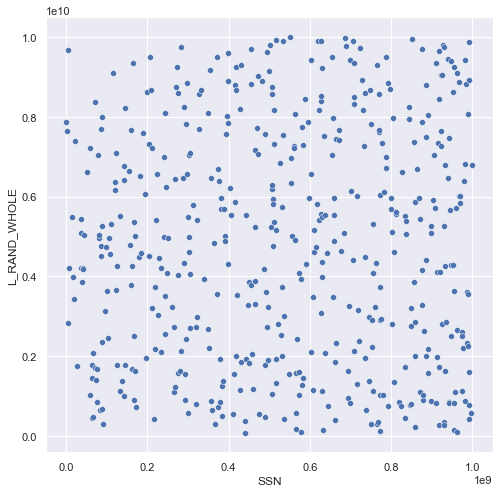

In [4]:
# Figure 1
plt.figure(figsize=(8, 8))
sns.scatterplot(data=python_df.astype(float), x="SSN", y="L_RAND_WHOLE")

# COBOL fixed point arithmetic replication
We will now replicate the algorithm using the fixed point arithmetic method from the COBOL, using python's `decimal` package.

In [5]:
# Pass the same 500 numbers through the COBOL code recreated using the decimal package and reusing the same seed
cobol_df = ran.generate_outcomes(
    low=1_01_0001,
    high=999_99_9999,
    size=500,
    process_type="cobol",
    generate_rand_whole=True,
)

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 576x576 with 0 Axes>

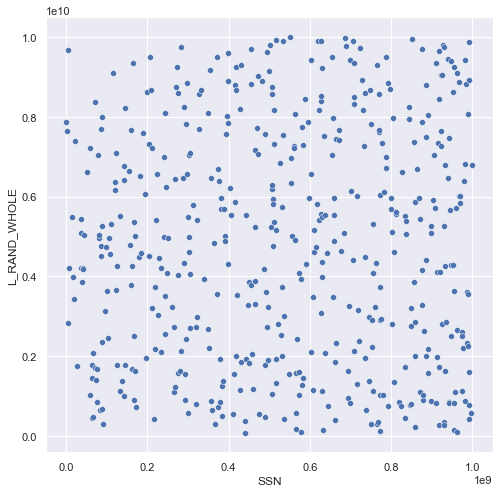

In [6]:
# Figure 2
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(data=cobol_df.astype(float), x="SSN", y="L_RAND_WHOLE")
ax.get_figure().savefig("figure_2.jpg")

In [7]:
# This demonstrates that the floating-point arithmetic provides a perfect negative correlation with a p-value of 0.
pearson, p_val = pearsonr(
    cobol_df.SSN.astype(float), cobol_df.L_RAND_WHOLE.astype(float)
)
print(
    f"COBOL implementation has a pearson correlation of {round(pearson,2)}, with a p-value of {round(p_val,2)}"
)

COBOL implementation has a pearson correlation of 0.03, with a p-value of 0.45


Essentially, the pseudo-randomness generated using COBOL's fixed point arithmetic should be equivalent to that generated by python. The only distinction comes from a rounding errors that are unique to each programming language. We have tested this behavior with multiple random samples of inputs, and were able to verify that the difference in the python generated outcomes and COBOL generted outcomes is always within 1.

The same 500 randomly generated SSN values as Figure 2 lead to output that seem sufficiently random.

# Step 2: Verifying "local" randomness


## A shuffling test

As another test of randomness, we draw draw 100 random integers between 0 and 1,000,000,000 and compute the Spearman ρ between the originally drawn list and the "hashed" list. The $p$-value of this ρ should be approximately uniformly distributed if we do this a lot of times, and, at least visually, this seems to be true.

  0%|          | 0/10000 [00:00<?, ?it/s]

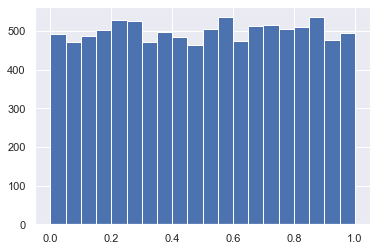

In [8]:
random = np.random.default_rng(2381923)
pvalues = []
for draws in tqdm(range(10_000)):
    original_ints = random.integers(0, 1_000_000_000, size=100)
    hashed_ints = [int(ran.cobol_hash(int(x)) * 10_000_000_000) for x in original_ints]
    pvalues.append(spearmanr(original_ints, hashed_ints).pvalue)

# This should look approximately uniform
plt.hist(pvalues, bins=20);

## A local shuffling test

As another test of randomness, we look at sequences of 100 consecutive integers and ask how well the algorithm shuffles them. As above, the $p$-values for the Spearman ρ should be uniform if this is a good randomizer. Note that they certainly are not.

  0%|          | 0/10000 [00:00<?, ?it/s]

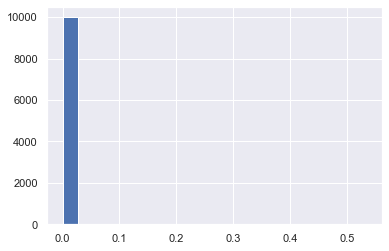

In [9]:
random = np.random.default_rng(2381923)
pvalues = []
for draws in tqdm(range(10_000)):
    lower_int = random.integers(0, 1_000_000_000 - 100)
    original_ints = np.arange(lower_int, lower_int + 100).astype(int)
    hashed_ints = [int(ran.cobol_hash(int(x)) * 10_000_000_000) for x in original_ints]
    pvalues.append(spearmanr(original_ints, hashed_ints).pvalue)

# This should look approximately uniform
plt.hist(pvalues, bins=20);

For a more graphic representation of what is causing this behavior, I have graphed a sequence of integers from 1,000,000 ~ 1,160,000.

Notice that SSN values are likely to retain their order if they are within 127,773 of each other. (i.e 001-01-1234 and 001-01-4567 will retain their order, where the latter will always be ranked higher than the former).

  0%|          | 0/160000 [00:00<?, ?it/s]

<AxesSubplot:xlabel='SSN', ylabel='L_RAND_WHOLE'>

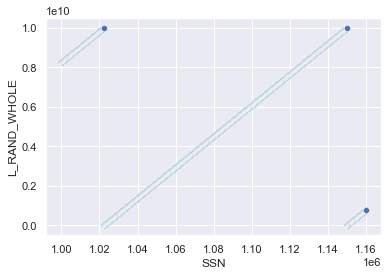

In [10]:
# Generate consecutive values
ran_df = ran.generate_outcomes(
    low=1_00_0000, high=1_16_0000, all_values=True, generate_rand_whole=True
)
sns.scatterplot(data=ran_df.astype(int), x="SSN", y="L_RAND_WHOLE")

We can also look at how bad this problem is by looking at different lengths of consecutive integers concatenated together.  
This models the case where, say, Massachusetts SSNs tend to begin in one range and Rhode Island SSNs tend to begin in another range. We note that this algorithm doesn't do a particularly good job here, either. Indeed, when utilizing _two_ consecutive ranges, its $p$-value distribution is almost identical to using _one_ consecutive range. It's only when you start approaching random inputs that you get random outputs.

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([999.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.02676982, 0.05353965, 0.08030947, 0.10707929,
        0.13384912, 0.16061894, 0.18738876, 0.21415859, 0.24092841,
        0.26769823, 0.29446806, 0.32123788, 0.34800771, 0.37477753,
        0.40154735, 0.42831718, 0.455087  , 0.48185682, 0.50862665,
        0.53539647]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 1')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([999.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.00091643, 0.00183287, 0.0027493 , 0.00366573,
        0.00458216, 0.0054986 , 0.00641503, 0.00733146, 0.00824789,
        0.00916433, 0.01008076, 0.01099719, 0.01191362, 0.01283006,
        0.01374649, 0.01466292, 0.01557935, 0.01649579, 0.01741222,
        0.01832865]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 2')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([829.,   0.,   0.,   0.,   0.,   0.,   0.,  88.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  83.]),
 array([0.        , 0.02686774, 0.05373547, 0.08060321, 0.10747095,
        0.13433869, 0.16120642, 0.18807416, 0.2149419 , 0.24180963,
        0.26867737, 0.29554511, 0.32241284, 0.34928058, 0.37614832,
        0.40301606, 0.42988379, 0.45675153, 0.48361927, 0.510487  ,
        0.53735474]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 4')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([730.,   0.,   0.,  54.,   0.,  74.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  90.,   0.,   0.,  52.]),
 array([0.        , 0.03467241, 0.06934481, 0.10401722, 0.13868962,
        0.17336203, 0.20803443, 0.24270684, 0.27737925, 0.31205165,
        0.34672406, 0.38139646, 0.41606887, 0.45074127, 0.48541368,
        0.52008609, 0.55475849, 0.5894309 , 0.6241033 , 0.65877571,
        0.69344812]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 5')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([540.,  69.,  64.,  26.,  34.,  35.,  17.,  28.,  14.,  16.,  26.,
         13.,  12.,  16.,  17.,  15.,  11.,  11.,  14.,  22.]),
 array([3.39240865e-32, 4.84639068e-02, 9.69278136e-02, 1.45391720e-01,
        1.93855627e-01, 2.42319534e-01, 2.90783441e-01, 3.39247348e-01,
        3.87711254e-01, 4.36175161e-01, 4.84639068e-01, 5.33102975e-01,
        5.81566882e-01, 6.30030788e-01, 6.78494695e-01, 7.26958602e-01,
        7.75422509e-01, 8.23886416e-01, 8.72350322e-01, 9.20814229e-01,
        9.69278136e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 10')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([377.,  83.,  62.,  52.,  31.,  28.,  40.,  28.,  32.,  29.,  29.,
         24.,  29.,  16.,  20.,  31.,  24.,  14.,  22.,  29.]),
 array([5.27113316e-14, 4.97636218e-02, 9.95272436e-02, 1.49290865e-01,
        1.99054487e-01, 2.48818109e-01, 2.98581731e-01, 3.48345353e-01,
        3.98108974e-01, 4.47872596e-01, 4.97636218e-01, 5.47399840e-01,
        5.97163462e-01, 6.46927083e-01, 6.96690705e-01, 7.46454327e-01,
        7.96217949e-01, 8.45981571e-01, 8.95745193e-01, 9.45508814e-01,
        9.95272436e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 20')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([355.,  80.,  58.,  46.,  41.,  45.,  30.,  45.,  32.,  33.,  22.,
         33.,  26.,  20.,  20.,  29.,  19.,  24.,  21.,  21.]),
 array([1.89893924e-15, 4.99858172e-02, 9.99716345e-02, 1.49957452e-01,
        1.99943269e-01, 2.49929086e-01, 2.99914903e-01, 3.49900721e-01,
        3.99886538e-01, 4.49872355e-01, 4.99858172e-01, 5.49843989e-01,
        5.99829807e-01, 6.49815624e-01, 6.99801441e-01, 7.49787258e-01,
        7.99773076e-01, 8.49758893e-01, 8.99744710e-01, 9.49730527e-01,
        9.99716345e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 25')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([175.,  68.,  62.,  60.,  37.,  44.,  44.,  50.,  53.,  41.,  35.,
         28.,  33.,  43.,  41.,  43.,  37.,  37.,  35.,  34.]),
 array([5.68665345e-06, 4.99817644e-02, 9.99578421e-02, 1.49933920e-01,
        1.99909998e-01, 2.49886075e-01, 2.99862153e-01, 3.49838231e-01,
        3.99814308e-01, 4.49790386e-01, 4.99766464e-01, 5.49742541e-01,
        5.99718619e-01, 6.49694697e-01, 6.99670775e-01, 7.49646852e-01,
        7.99622930e-01, 8.49599008e-01, 8.99575085e-01, 9.49551163e-01,
        9.99527241e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 50')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([61., 53., 42., 39., 47., 50., 51., 51., 42., 45., 61., 43., 45.,
        57., 41., 50., 51., 48., 63., 60.]),
 array([0.00194154, 0.051679  , 0.10141646, 0.15115391, 0.20089137,
        0.25062883, 0.30036629, 0.35010374, 0.3998412 , 0.44957866,
        0.49931612, 0.54905358, 0.59879103, 0.64852849, 0.69826595,
        0.74800341, 0.79774086, 0.84747832, 0.89721578, 0.94695324,
        0.9966907 ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 100')

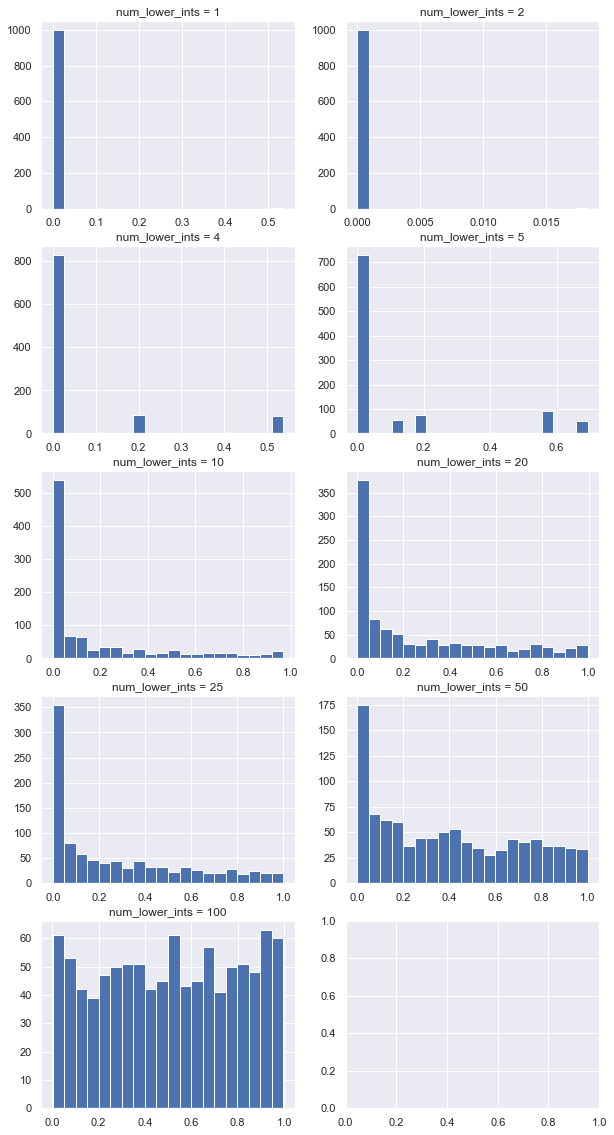

In [11]:
random = np.random.default_rng(2381923)
all_pvalues = {}
width = 100
all_num_lower_ints = [1, 2, 4, 5, 10, 20, 25, 50, 100]

fig, axs = plt.subplots(len(all_num_lower_ints) // 2 + 1, 2, figsize=(10, 20))

for num_lower_ints, ax in zip(all_num_lower_ints, axs.flatten()):
    pvalues = []
    local_width = width // num_lower_ints
    width_range = np.arange(local_width).astype(int)
    for draws in tqdm(range(1000)):
        while True:
            lower_ints = random.integers(
                0, 1_000_000_000 - local_width, size=num_lower_ints
            )

            original_ints = (
                lower_ints[np.newaxis, :] + width_range[:, np.newaxis]
            ).flatten()
            original_ints = np.unique(original_ints)

            if len(original_ints) != num_lower_ints * local_width:
                # For the sake of consistency make sure we always have the same range width
                continue
            break
        hashed_ints = [
            int(ran.cobol_hash(int(x)) * 10_000_000_000) for x in original_ints
        ]
        pvalues.append(spearmanr(original_ints, hashed_ints).pvalue)
    all_pvalues[num_lower_ints] = pvalues

    # This should look approximately uniform
    ax.hist(pvalues, bins=20)
    ax.set_title(f"num_lower_ints = {num_lower_ints}");

On the other hand, we note that it is completely possible to get a "good enough"
local randomization via a more standard hashing algorithm like SHA256. Here we run the
same test as the previous cell, but instead of using the DoIT has, we run the
hexadecimal representation of a the SSN through SHA256 and keep the top several bytes
of the resulting digest as our randomization. We see that the resulting $p$-values
seem reasonably uniform at any width.

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([55., 50., 52., 47., 58., 58., 45., 48., 50., 46., 37., 53., 42.,
        47., 52., 48., 42., 55., 47., 68.]),
 array([8.69330996e-05, 5.00778589e-02, 1.00068785e-01, 1.50059710e-01,
        2.00050636e-01, 2.50041562e-01, 3.00032488e-01, 3.50023413e-01,
        4.00014339e-01, 4.50005265e-01, 4.99996191e-01, 5.49987116e-01,
        5.99978042e-01, 6.49968968e-01, 6.99959894e-01, 7.49950819e-01,
        7.99941745e-01, 8.49932671e-01, 8.99923597e-01, 9.49914522e-01,
        9.99905448e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 1')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([47., 48., 62., 62., 38., 56., 44., 61., 39., 53., 41., 44., 49.,
        55., 40., 48., 57., 57., 50., 49.]),
 array([1.38847040e-05, 5.00037353e-02, 9.99935859e-02, 1.49983436e-01,
        1.99973287e-01, 2.49963138e-01, 2.99952988e-01, 3.49942839e-01,
        3.99932689e-01, 4.49922540e-01, 4.99912391e-01, 5.49902241e-01,
        5.99892092e-01, 6.49881942e-01, 6.99871793e-01, 7.49861643e-01,
        7.99851494e-01, 8.49841345e-01, 8.99831195e-01, 9.49821046e-01,
        9.99810896e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 2')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([56., 56., 44., 44., 48., 49., 49., 51., 60., 50., 43., 49., 49.,
        39., 57., 54., 49., 45., 61., 47.]),
 array([0.00154135, 0.05143592, 0.10133049, 0.15122505, 0.20111962,
        0.25101419, 0.30090875, 0.35080332, 0.40069789, 0.45059245,
        0.50048702, 0.55038159, 0.60027616, 0.65017072, 0.70006529,
        0.74995986, 0.79985442, 0.84974899, 0.89964356, 0.94953812,
        0.99943269]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 4')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([54., 51., 46., 50., 45., 33., 39., 50., 42., 64., 60., 47., 63.,
        42., 56., 60., 41., 62., 47., 48.]),
 array([2.47898661e-04, 5.02165934e-02, 1.00185288e-01, 1.50153983e-01,
        2.00122677e-01, 2.50091372e-01, 3.00060067e-01, 3.50028762e-01,
        3.99997456e-01, 4.49966151e-01, 4.99934846e-01, 5.49903540e-01,
        5.99872235e-01, 6.49840930e-01, 6.99809625e-01, 7.49778319e-01,
        7.99747014e-01, 8.49715709e-01, 8.99684403e-01, 9.49653098e-01,
        9.99621793e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 5')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([47., 48., 45., 54., 43., 56., 37., 51., 49., 61., 46., 67., 39.,
        40., 51., 60., 60., 51., 50., 45.]),
 array([7.82982942e-04, 5.06492821e-02, 1.00515581e-01, 1.50381880e-01,
        2.00248179e-01, 2.50114479e-01, 2.99980778e-01, 3.49847077e-01,
        3.99713376e-01, 4.49579675e-01, 4.99445974e-01, 5.49312273e-01,
        5.99178572e-01, 6.49044871e-01, 6.98911171e-01, 7.48777470e-01,
        7.98643769e-01, 8.48510068e-01, 8.98376367e-01, 9.48242666e-01,
        9.98108965e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 10')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([57., 42., 53., 43., 61., 41., 52., 58., 46., 51., 42., 54., 47.,
        50., 52., 53., 48., 38., 54., 58.]),
 array([0.00706711, 0.05661447, 0.10616184, 0.15570921, 0.20525657,
        0.25480394, 0.3043513 , 0.35389867, 0.40344603, 0.4529934 ,
        0.50254076, 0.55208813, 0.60163549, 0.65118286, 0.70073022,
        0.75027759, 0.79982495, 0.84937232, 0.89891968, 0.94846705,
        0.99801441]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 20')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([57., 49., 55., 54., 36., 46., 48., 46., 44., 42., 49., 59., 60.,
        50., 60., 45., 50., 53., 42., 55.]),
 array([6.03327586e-04, 5.04691543e-02, 1.00334981e-01, 1.50200808e-01,
        2.00066635e-01, 2.49932461e-01, 2.99798288e-01, 3.49664115e-01,
        3.99529941e-01, 4.49395768e-01, 4.99261595e-01, 5.49127422e-01,
        5.98993248e-01, 6.48859075e-01, 6.98724902e-01, 7.48590729e-01,
        7.98456555e-01, 8.48322382e-01, 8.98188209e-01, 9.48054036e-01,
        9.97919862e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 25')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([53., 60., 49., 48., 56., 52., 56., 38., 50., 49., 44., 53., 49.,
        48., 52., 55., 44., 41., 58., 45.]),
 array([4.76638590e-04, 5.03677101e-02, 1.00258782e-01, 1.50149853e-01,
        2.00040925e-01, 2.49931996e-01, 2.99823068e-01, 3.49714139e-01,
        3.99605211e-01, 4.49496282e-01, 4.99387354e-01, 5.49278425e-01,
        5.99169497e-01, 6.49060568e-01, 6.98951640e-01, 7.48842711e-01,
        7.98733782e-01, 8.48624854e-01, 8.98515925e-01, 9.48406997e-01,
        9.98298068e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 50')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([62., 62., 59., 57., 36., 49., 39., 49., 51., 50., 40., 70., 52.,
        55., 47., 45., 41., 45., 47., 44.]),
 array([2.53429462e-04, 5.02360304e-02, 1.00218631e-01, 1.50201232e-01,
        2.00183833e-01, 2.50166434e-01, 3.00149035e-01, 3.50131636e-01,
        4.00114237e-01, 4.50096838e-01, 5.00079439e-01, 5.50062040e-01,
        6.00044641e-01, 6.50027242e-01, 7.00009843e-01, 7.49992443e-01,
        7.99975044e-01, 8.49957645e-01, 8.99940246e-01, 9.49922847e-01,
        9.99905448e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 100')

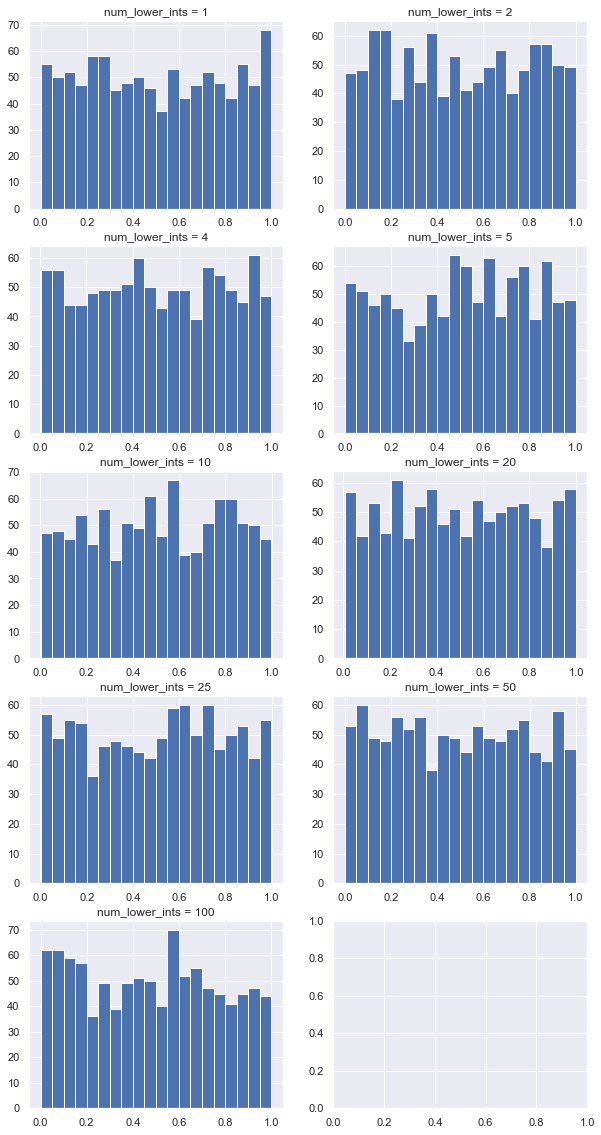

In [12]:
random = np.random.default_rng(2381923)
all_pvalues = {}
width = 100
all_num_lower_ints = [1, 2, 4, 5, 10, 20, 25, 50, 100]

fig, axs = plt.subplots(len(all_num_lower_ints) // 2 + 1, 2, figsize=(10, 20))

for num_lower_ints, ax in zip(all_num_lower_ints, axs.flatten()):
    pvalues = []
    local_width = width // num_lower_ints
    width_range = np.arange(local_width).astype(int)
    for draws in tqdm(range(1000)):
        while True:
            lower_ints = random.integers(
                0, 1_000_000_000 - local_width, size=num_lower_ints
            )

            original_ints = (
                lower_ints[np.newaxis, :] + width_range[:, np.newaxis]
            ).flatten()
            original_ints = np.unique(original_ints)

            if len(original_ints) != num_lower_ints * local_width:
                # For the sake of consistency make sure we always have the same range width
                continue
            break
        hashed_ints = [
            int(hashlib.sha256(hex(x).encode("utf8")).hexdigest()[:16], 16)
            for x in original_ints
        ]
        pvalues.append(spearmanr(original_ints, hashed_ints).pvalue)
    all_pvalues[num_lower_ints] = pvalues

    # This should look approximately uniform
    ax.hist(pvalues, bins=20)
    ax.set_title(f"num_lower_ints = {num_lower_ints}");

# A potential solution
Hardware limitations have prevented us from implementing a SHA. So, we need to create our own randomization scheme that can ensure that the input SSN is sufficiently random by guarenteeing a certain level of both 'global' and 'local' randomness.

The solution is as follows:  
For each SSN, we will add the 6 digit micro-seconds maintained in UNIX. Then, the resulting sum value will be reversed.
In the pythonic implementation, the 6 digit miliseconds will be captured using the `time.time()` function, truncated to the first 6 digits.
The existing DoIT algorithm already has a check for duplicates, where the seed-number is replaced with the current `WS-DATE-TIME`. 

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([66., 46., 40., 47., 51., 37., 43., 55., 55., 55., 49., 50., 47.,
        58., 45., 55., 51., 49., 52., 49.]),
 array([7.19727030e-06, 4.99926546e-02, 9.99781120e-02, 1.49963569e-01,
        1.99949027e-01, 2.49934484e-01, 2.99919941e-01, 3.49905399e-01,
        3.99890856e-01, 4.49876314e-01, 4.99861771e-01, 5.49847228e-01,
        5.99832686e-01, 6.49818143e-01, 6.99803600e-01, 7.49789058e-01,
        7.99774515e-01, 8.49759972e-01, 8.99745430e-01, 9.49730887e-01,
        9.99716345e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 1')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([50., 36., 43., 42., 43., 52., 60., 43., 53., 50., 42., 59., 50.,
        58., 45., 42., 61., 58., 56., 57.]),
 array([6.84713905e-05, 4.98759449e-02, 9.96834184e-02, 1.49490892e-01,
        1.99298365e-01, 2.49105839e-01, 2.98913312e-01, 3.48720786e-01,
        3.98528259e-01, 4.48335733e-01, 4.98143206e-01, 5.47950680e-01,
        5.97758153e-01, 6.47565627e-01, 6.97373100e-01, 7.47180574e-01,
        7.96988047e-01, 8.46795521e-01, 8.96602994e-01, 9.46410468e-01,
        9.96217941e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 2')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([35., 42., 55., 42., 40., 51., 53., 56., 46., 48., 60., 49., 45.,
        45., 52., 52., 51., 55., 61., 62.]),
 array([0.00190999, 0.05178613, 0.10166226, 0.1515384 , 0.20141453,
        0.25129067, 0.3011668 , 0.35104294, 0.40091907, 0.45079521,
        0.50067134, 0.55054748, 0.60042361, 0.65029975, 0.70017588,
        0.75005202, 0.79992815, 0.84980428, 0.89968042, 0.94955655,
        0.99943269]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 4')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([55., 44., 40., 41., 40., 51., 58., 47., 53., 44., 45., 56., 47.,
        60., 52., 57., 43., 51., 55., 61.]),
 array([0.00233972, 0.0520809 , 0.10182209, 0.15156328, 0.20130446,
        0.25104565, 0.30078684, 0.35052802, 0.40026921, 0.4500104 ,
        0.49975158, 0.54949277, 0.59923396, 0.64897514, 0.69871633,
        0.74845752, 0.7981987 , 0.84793989, 0.89768108, 0.94742226,
        0.99716345]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 5')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([47., 39., 49., 50., 54., 53., 36., 50., 46., 37., 48., 64., 47.,
        61., 57., 50., 57., 55., 48., 52.]),
 array([0.00173478, 0.05160076, 0.10146675, 0.15133273, 0.20119872,
        0.2510647 , 0.30093069, 0.35079667, 0.40066266, 0.45052864,
        0.50039463, 0.55026061, 0.6001266 , 0.64999259, 0.69985857,
        0.74972456, 0.79959054, 0.84945653, 0.89932251, 0.9491885 ,
        0.99905448]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 10')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([49., 61., 51., 44., 58., 42., 45., 50., 52., 41., 39., 45., 54.,
        60., 56., 47., 49., 57., 45., 55.]),
 array([0.00282295, 0.05266289, 0.10250283, 0.15234278, 0.20218272,
        0.25202266, 0.3018626 , 0.35170254, 0.40154249, 0.45138243,
        0.50122237, 0.55106231, 0.60090226, 0.6507422 , 0.70058214,
        0.75042208, 0.80026202, 0.85010197, 0.89994191, 0.94978185,
        0.99962179]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 20')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([47., 60., 49., 33., 40., 39., 48., 62., 52., 50., 53., 60., 44.,
        53., 48., 59., 42., 54., 60., 47.]),
 array([9.12336755e-04, 5.07485303e-02, 1.00584724e-01, 1.50420917e-01,
        2.00257111e-01, 2.50093305e-01, 2.99929498e-01, 3.49765692e-01,
        3.99601885e-01, 4.49438079e-01, 4.99274272e-01, 5.49110466e-01,
        5.98946659e-01, 6.48782853e-01, 6.98619047e-01, 7.48455240e-01,
        7.98291434e-01, 8.48127627e-01, 8.97963821e-01, 9.47800014e-01,
        9.97636208e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 25')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([31., 26., 42., 32., 40., 35., 42., 49., 57., 60., 49., 57., 61.,
        48., 54., 71., 59., 73., 64., 50.]),
 array([0.00918484, 0.05866886, 0.10815289, 0.15763692, 0.20712095,
        0.25660497, 0.306089  , 0.35557303, 0.40505705, 0.45454108,
        0.50402511, 0.55350913, 0.60299316, 0.65247719, 0.70196122,
        0.75144524, 0.80092927, 0.8504133 , 0.89989732, 0.94938135,
        0.99886538]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 50')

  0%|          | 0/1000 [00:00<?, ?it/s]

(array([55., 53., 52., 43., 53., 48., 46., 65., 46., 45., 50., 57., 42.,
        54., 49., 51., 38., 49., 51., 53.]),
 array([2.80968797e-04, 5.00825450e-02, 9.98841211e-02, 1.49685697e-01,
        1.99487273e-01, 2.49288850e-01, 2.99090426e-01, 3.48892002e-01,
        3.98693578e-01, 4.48495154e-01, 4.98296730e-01, 5.48098306e-01,
        5.97899883e-01, 6.47701459e-01, 6.97503035e-01, 7.47304611e-01,
        7.97106187e-01, 8.46907763e-01, 8.96709340e-01, 9.46510916e-01,
        9.96312492e-01]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'num_lower_ints = 100')

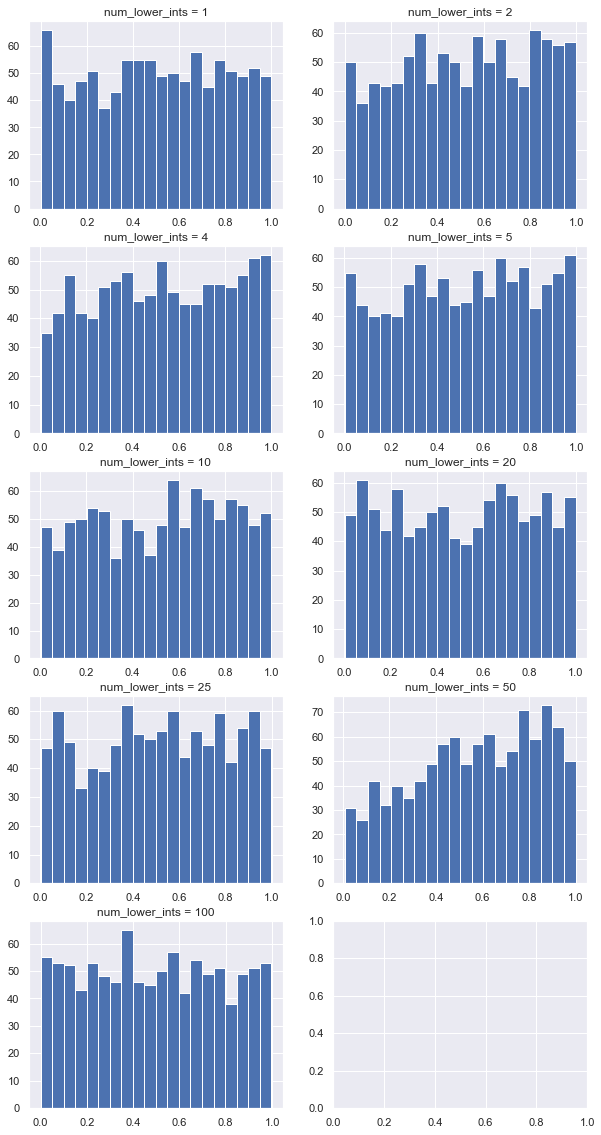

In [13]:
# run the same local test as above
random = np.random.default_rng(2381923)
all_pvalues = {}
width = 100
all_num_lower_ints = [1, 2, 4, 5, 10, 20, 25, 50, 100]

fig, axs = plt.subplots(len(all_num_lower_ints) // 2 + 1, 2, figsize=(10, 20))

for num_lower_ints, ax in zip(all_num_lower_ints, axs.flatten()):
    pvalues = []
    local_width = width // num_lower_ints
    width_range = np.arange(local_width).astype(int)
    for draws in tqdm(range(1000)):
        while True:
            lower_ints = random.integers(
                0, 1_000_000_000 - local_width, size=num_lower_ints
            )

            original_ints = (
                lower_ints[np.newaxis, :] + width_range[:, np.newaxis]
            ).flatten()
            original_ints = np.unique(original_ints)

            if len(original_ints) != num_lower_ints * local_width:
                # For the sake of consistency make sure we always have the same range width
                continue
            break
        # Modify the seeds by adding miliseconds
        new_ints = list(map(ran.add_ms_to_seed, original_ints))
        hashed_ints = [int(ran.cobol_hash(int(x)) * 10_000_000_000) for x in new_ints]
        pvalues.append(spearmanr(original_ints, hashed_ints).pvalue)
    all_pvalues[num_lower_ints] = pvalues

    # This should look approximately uniform
    ax.hist(pvalues, bins=20)
    ax.set_title(f"num_lower_ints = {num_lower_ints}");

The solution actually skews to higher p-values, especially in the areas with smaller p-values. 

While this skew is certainly not ideal, that it is skewed to higher $p$-values is preferable. Moreover, the origin of the skew is a bit mysterious and may be due in part to the fact that we are requesting the current time in much shorter intervals that what might actually occur in DLT's mainframe. We will explore this issue in the next section.

Further, we will look at any issues this less-than-ideal randomness may have caused by utilizing the balance tests described in the pre-analysis plan.

# Verifying the randomness of millisecond values from DLT mainframe

We received the output of requesting 5,000 sequential timestamps from DLT's mainframe to give us an idea of how random sequential values from the mainframe tend to be. The format of each of the 10 digit numbers we received were "MMSSSSSSSS", that is, the minutes, seconds, and milliseconds of the current time written as an integer.

(array([489., 495., 523., 496., 530., 458., 507., 506., 484., 512.]),
 array([8.75130000e+04, 9.99955513e+08, 1.99982351e+09, 2.99969151e+09,
        3.99955951e+09, 4.99942751e+09, 5.99929551e+09, 6.99916351e+09,
        7.99903151e+09, 8.99889951e+09, 9.99876751e+09]),
 <BarContainer object of 10 artists>)

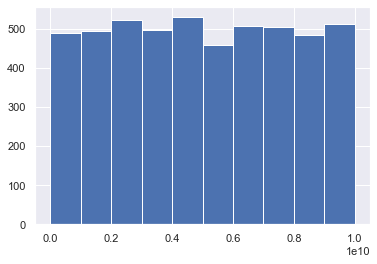

In [14]:
# Make sure the value are uniformly distributed over the course of 5000 calls

df = pd.read_csv(
    Path(get_global_config().DATA_DIR) / "reference" / "5000datetimes.csv",
    skiprows=1,
    usecols=[0],
)
df.columns = ["DATETIME"]
df["REV"] = df.DATETIME.astype(str).apply(lambda x: x[::-1]).astype(int)
plt.hist(df.REV)

(array([ 1.,  3.,  4., 10.,  5.,  6.,  6.,  5.,  5.,  5.]),
 array([0.01026077, 0.1069374 , 0.20361403, 0.30029065, 0.39696728,
        0.4936439 , 0.59032053, 0.68699716, 0.78367378, 0.88035041,
        0.97702703]),
 <BarContainer object of 10 artists>)

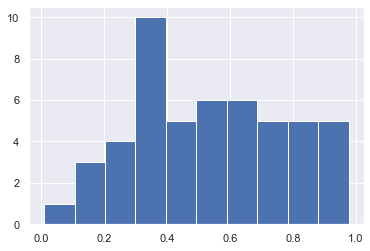

In [15]:
# Then look at local runs similar to the above runs. Note that it has the same shape as what
# we were seeing in the Python based reversed datetimes. There's almost certainly a reason
# for this but we cannot place it at the moment.
pvalues = [
    spearmanr(np.arange(100), df["REV"].iloc[left : left + 100]).pvalue
    for left in range(0, 5000, 100)
]
plt.hist(pvalues)

In [16]:
df.DATETIME.diff().describe()

count     4999.000000
mean       751.184837
std        241.137138
min        704.000000
25%        732.000000
50%        742.000000
75%        755.000000
max      12630.000000
Name: DATETIME, dtype: float64

Calling the datetime function seems to reliably add ~750 milliseconds to each process. This is sufficient verification that the AS/400 is capable of adding random noise through small units of time.

# Verifying injectivity

Finally, we want to check if this function actually is _injective_, i.e., that it takes
distinct inputs to distinct outputs. This is not unreasonable to expect because the
function's range is 10x the size of its domain, but still we double check. However,
doing so in Python is incredibly time and memory consuming. So we have a small
script in Rust that performs this check.

The script is contained in `src/rust/check-hash-injectivity.rs`. To build it, run
```
cargo build --release
./target/release/dlt-check-hash-injectivity
```

Note that it will take quite a long time and is not particularly memory efficient.